参考资料：

<!-- * [https://python.langchain.com/docs/how_to/tools_few_shot/](https://python.langchain.com/docs/how_to/tools_few_shot/) -->

In [ ]:
from dotenv import load_dotenv

load_dotenv()

import json
from typing import Literal
from langgraph.graph import END, StateGraph, START
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.tools import tool
from langchain.output_parsers import PydanticOutputParser
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

memory = MemorySaver()
model_name = "gpt-4o-mini"

In [ ]:
@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

In [ ]:
# 在系统提示词中，暗示大模型它的数据能力不行，要求它使用工具完成计算。
# 不然，它就直接算出结果，本实验就没有意义了。
system_prompt = """You are bad at math but are an expert at using a calculator. 
Use past tool usage as an example of how to correctly use the tools.
You can only call a tool at a time.
Please step by step to solve problem.
"""

examples = [
    HumanMessage("317253 x 128472 + 4 = ?"),
    AIMessage(
        "",
        tool_calls=[
            {"name": "multiply", "args": {"x": 317253, "y": 128472}, "id": "111"}
        ],
    ),
    ToolMessage("40758127416", tool_call_id="111"),
    AIMessage(
        "",
        tool_calls=[{"name": "add", "args": {"x": "40758127416", "y": 4}, "id": "222"}],
    ),
    ToolMessage("40758127420", tool_call_id="222"),
    AIMessage(
        "317253 x 128472 + 4 = 40758127420",
    ),
]

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    is_valid: bool
    query: str
    summary_text: str
    start: bool = False

def chatbot(state: State):
    tools = [add, multiply]
    # 使用模型绑定工具
    llm = ChatOpenAI(model=model_name)
    llm_with_tools = llm.bind_tools(tools)
    
    chat_template = ChatPromptTemplate.from_messages([
        SystemMessage(system_prompt),
        # example
        HumanMessage("The following is an example."),
        *examples,
        # query
        HumanMessage("Refer to the above example to solve the following problems:\n"),
        *state["messages"],
    ])
    chain = chat_template | llm_with_tools
    ai_answer = [chain.invoke({})]
    
    start = state["start"]
    if start is False:
        start = True
        query = state["messages"][-1].content
        return {"query": query, "start": True, "messages": ai_answer}

    return {"messages": ai_answer}

In [ ]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [ ]:
def route_chatbot(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    # 转移到 valid 节点
    return "valid"


def valid_node(state: State):
    """
    浏览之前所有的message，判断计算结果是否正确？
    """
    end_format = """
    返回格式：
    {
    "valid": true  # 或 false
    }
    """.strip()
    
    chat_prompt = ChatPromptTemplate.from_messages([
        HumanMessage(content="判断下述大模型的数学工具的参数传递与调用是否正确。"),
        HumanMessage(f"用户问题如下所示:\n{state["query"]}"),
        HumanMessage(f"计算过程如下所示:\n {state["messages"][-1].content}\n{end_format}"),
        # *state["messages"][1:],
    ])

    class Binary_Answer(BaseModel):
        """判断数学计算过程是否正确，判断工具的调用是否能得到正确的结果"""

        valid: bool = Field(description="返回True代表计算正确，否则返回False")

    parser = PydanticOutputParser(pydantic_object=Binary_Answer)
    llm = ChatOpenAI(model=model_name)
    chain = chat_prompt | llm | parser
    valid_answer = chain.invoke({})
    # print("valid_answer", valid_answer)
    if valid_answer:
        return {"is_valid": valid_answer.valid}
    else:
        return {"is_valid": False}

def route_valid(state: State) -> Literal["summary", END]:
    is_valid = state["is_valid"]
    if is_valid:
        return "summary"
    return END

def summary(state: State):
    """
    总结上述计算过程
    """
    chat_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="总结下述计算过程。"),
        *state["messages"],
    ])
    llm = ChatOpenAI(model=model_name)
    chain = chat_prompt | llm
    return {"summary_text": chain.invoke({})}

In [14]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

# tool
tool_node = BasicToolNode(tools=[add, multiply])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    route_chatbot,
    {"tools": "tools", "valid": "valid"},
)

graph_builder.add_node("valid", valid_node)
graph_builder.add_conditional_edges(
    "valid",
    route_valid,
    {"summary": "summary", END: END},
)

graph_builder.add_node("summary", summary)
graph_builder.add_edge("summary", END)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph = graph_builder.compile(checkpointer=memory)

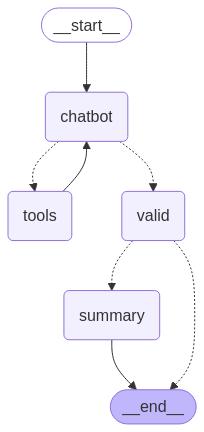

In [15]:
graph

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}], "start": False},
        config={"configurable": {"thread_id": "2"}},
    ):
        for value in event.values():
            print(value)
            # if "messages" in value.keys():
            #     print(event, "Assistant:", value["messages"][-1].content)

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    stream_graph_updates(user_input)

{'query': '10 + 3 + 7 = ', 'start': True, 'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r5nmikxuU9PGcduLuzxe4fAG', 'function': {'arguments': '{"a": 10, "b": 3}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_NhBpc5DnYm3XEY7pZz0lootP', 'function': {'arguments': '{"a": 10, "b": 7}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 272, 'total_tokens': 323, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_ded0d14823', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e0d6e9b4-2f73-4542-9b66-2d9e606ab342-0', tool_calls=[{'name': 'add', 'args': {'a': 10, 'b': 3}, 'id': 'call_r5nmikxuU9PGcduLuzxe4fAG', 'type': 'tool_call'}, {'name': 'add', 'ar

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}], "start": False},
        config={"configurable": {"thread_id": "2"}},
    ):
        if "messages" in event:
            event["messages"][-1].pretty_print()
        else:
            print(event)


while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    stream_graph_updates(user_input)